In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import plotly.express as px
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from pathlib import Path
from sklearn.metrics import adjusted_rand_score

warnings.filterwarnings("ignore")


In [2]:
# Initialize workflow parameters
num_top = 50
data_path = Path(f'../data/top_{num_top}_companies_by_sector.csv').resolve()
analysis_start = "2023-01-01"
analysis_end = "2025-05-27"
data = pd.read_csv(data_path)
data

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap (B),Country,IPO Year,Volume,Sector,Industry
0,UFPI,UFP Industries Inc. Common Stock,$115.67,-0.7900,-0.678%,7.024022,United States,1993.0,223820,Basic Materials,Forest Products
1,AMWD,American Woodmark Corporation Common Stock,$77.01,0.4800,0.627%,1.159322,United States,1986.0,168642,Basic Materials,Forest Products
2,IPX,IperionX Limited American Depositary Share,$26.52,0.1200,0.455%,0.682213,United States,NaN,50560,Basic Materials,Other Metals and Minerals
3,EU,enCore Energy Corp. Common Shares,$2.91,0.0600,2.105%,0.541518,United States,NaN,1091464,Basic Materials,Other Metals and Minerals
4,USGO,U.S. GoldMining Inc. Common stock,$12.59,1.7800,16.466%,0.156678,United States,2023.0,225247,Basic Materials,Precious Metals
...,...,...,...,...,...,...,...,...,...,...,...
524,VIVK,Vivakor Inc. Common Stock,$0.845,-0.0248,-2.851%,0.028424,United States,NaN,42549,Utilities,Environmental Services
525,SONM,Sonim Technologies Inc. Common Stock,$2.55,-0.0800,-3.042%,0.012423,United States,2019.0,15396,Utilities,Telecommunications Equipment
526,CLRO,ClearOne Inc. (DE) Common Stock,$0.4926,-0.0072,-1.441%,0.011807,United States,NaN,87213,Utilities,Telecommunications Equipment
527,SUNE,SUNation Energy Inc. Common Stock,$1.225,-0.0950,-7.197%,0.002223,United States,NaN,87057,Utilities,Telecommunications Equipment


In [3]:
ticker = data['Symbol'].to_list()
company_name_ticker = data[['Name', 'Symbol']]
market_ticker = '^GSPC'
ticker.append(market_ticker)
company_name_ticker

,Name,Symbol
0,UFP Industries Inc. Common Stock,UFPI
1,American Woodmark Corporation Common Stock,AMWD
2,IperionX Limited American Depositary Share,IPX
3,enCore Energy Corp. Common Shares,EU
4,U.S. GoldMining Inc. Common stock,USGO
...,...,...
524,Vivakor Inc. Common Stock,VIVK
525,Sonim Technologies Inc. Common Stock,SONM
526,ClearOne Inc. (DE) Common Stock,CLRO
527,SUNation Energy Inc. Common Stock,SUNE


In [4]:
stock_price = yf.download(tickers=ticker, start = analysis_start, end = analysis_end)['Close'].dropna(axis = 1)
stock_price

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  530 of 530 completed

21 Failed downloads:
['NXPLW', 'NEOVW', 'ARKOW', 'ADNWW', 'ANNAW', 'AMODW', 'NIOBW', 'NEHCW', 'DHCNL', 'SLDPW', 'NESRW', 'ZEOWW', 'USGOW', 'DFLIW', 'FOXXW', 'MVSTW', 'RMCOW', 'HYMCW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2025-05-27)')
['INFN', 'ROIC']: HTTPError('HTTP Error 404: ')
['QRTEP']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,12.74,49.397846,123.470612,6.540,84.900002,21.400000,3.99,336.920013,156.076004,50.400002,...,42.992443,33.680000,260.200012,79.400002,10.34,32.820000,43.790588,66.660004,110.190002,3824.139893
2023-01-04,13.59,47.311817,124.744125,7.710,88.720001,21.139999,3.92,341.410004,159.400238,50.700001,...,42.916397,35.610001,262.989990,80.620003,10.32,34.740002,45.390041,67.650002,111.589996,3852.969971
2023-01-05,13.99,46.539463,123.421265,7.350,87.709999,21.790001,3.92,328.440002,153.424316,49.200001,...,41.937351,35.099998,260.059998,79.220001,10.31,34.250000,44.594830,65.620003,104.389999,3808.100098
2023-01-06,14.18,48.975353,127.962410,7.545,88.519997,22.379999,3.95,332.750000,159.025543,52.799999,...,42.479160,35.880001,273.420013,80.540001,10.31,34.959999,46.320789,69.510002,103.959999,3895.080078
2023-01-09,14.61,49.120583,128.485641,8.385,89.239998,22.750000,3.96,341.980011,160.543579,51.900002,...,42.346081,38.750000,279.290009,82.120003,10.33,37.779999,46.103920,70.080002,104.750000,3892.090088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-19,11.86,106.360001,208.779999,1.390,136.600006,6.410000,3.77,420.679993,224.539993,2.260000,...,33.459999,67.790001,297.820007,32.840000,1.59,66.839996,49.080002,83.309998,252.570007,5963.600098
2025-05-20,11.65,104.529999,206.860001,1.390,132.130005,6.490000,3.82,417.609985,224.490005,2.200000,...,33.419998,67.180000,296.970001,32.730000,1.62,66.330002,48.630001,83.099998,251.949997,5940.459961
2025-05-21,11.24,100.510002,202.089996,1.320,127.519997,6.550000,3.78,414.029999,222.220001,2.090000,...,33.099998,65.250000,287.920013,30.850000,1.60,64.419998,46.639999,82.269997,248.720001,5844.609863


In [5]:
returns = stock_price.pct_change().dropna()
ticker = [col for col in stock_price.columns if col != market_ticker]
ticker.remove('DATSW')
stock_returns = returns[ticker]
market_returns = returns[market_ticker]
stock_returns

Ticker,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.066719,-0.042229,0.010314,0.178899,0.044994,-0.012150,-0.017544,0.013327,0.021299,0.005952,...,-0.132075,-0.001769,0.057304,0.010722,0.015365,-0.001934,0.058501,0.036525,0.014851,0.012705
2023-01-05,0.029433,-0.016325,-0.010605,-0.046693,-0.011384,0.030747,0.000000,-0.037990,-0.037490,-0.029586,...,-0.086957,-0.022813,-0.014322,-0.011141,-0.017365,-0.000969,-0.014105,-0.017520,-0.030007,-0.064522
2023-01-06,0.013581,0.052340,0.036794,0.026531,0.009235,0.027077,0.007653,0.013123,0.036508,0.073171,...,-0.077381,0.012919,0.022222,0.051373,0.016662,0.000000,0.020730,0.038703,0.059281,-0.004119
2023-01-09,0.030324,0.002965,0.004089,0.111332,0.008134,0.016533,0.002532,0.027739,0.009546,-0.017045,...,-0.077419,-0.003133,0.079989,0.021469,0.019618,0.001940,0.080664,-0.004682,0.008200,0.007599
2023-01-10,0.039699,0.016127,0.004456,-0.042934,-0.007844,0.083516,0.035354,-0.009591,0.012687,0.023121,...,0.034965,-0.001796,0.054452,0.027355,0.010716,0.000000,0.051615,0.000392,0.011130,0.002100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-19,0.000000,-0.004772,-0.011739,-0.103226,-0.010145,0.045677,0.013441,0.008511,-0.011316,-0.058333,...,-0.200000,0.017330,-0.028936,-0.009314,0.007671,0.019231,-0.027923,-0.002844,-0.015481,0.004255
2025-05-20,-0.017707,-0.017206,-0.009196,0.000000,-0.032723,0.012480,0.013263,-0.007298,-0.000223,-0.026549,...,0.178947,-0.001195,-0.008998,-0.002854,-0.003350,0.018868,-0.007630,-0.009169,-0.002521,-0.002455
2025-05-21,-0.035193,-0.038458,-0.023059,-0.050360,-0.034890,0.009245,-0.010471,-0.008573,-0.010112,-0.050000,...,-0.156250,-0.009575,-0.028729,-0.030474,-0.057440,-0.012346,-0.028795,-0.040921,-0.009988,-0.012820


In [6]:
sector_stocks = data[['Symbol', 'Sector']]
sector_stocks_cleaned = sector_stocks[sector_stocks['Symbol'].apply(lambda x: x in ticker)]
sector_stocks_cleaned_with_name = pd.merge(sector_stocks_cleaned, company_name_ticker, left_on='Symbol', right_on = 'Symbol')
sector_stocks_cleaned_with_name

,Symbol,Sector,Name
0,UFPI,Basic Materials,UFP Industries Inc. Common Stock
1,AMWD,Basic Materials,American Woodmark Corporation Common Stock
2,IPX,Basic Materials,IperionX Limited American Depositary Share
3,EU,Basic Materials,enCore Energy Corp. Common Shares
4,USAU,Basic Materials,U.S. Gold Corp. Common Stock
...,...,...,...
480,VIVK,Utilities,Vivakor Inc. Common Stock
481,SONM,Utilities,Sonim Technologies Inc. Common Stock
482,CLRO,Utilities,ClearOne Inc. (DE) Common Stock
483,SUNE,Utilities,SUNation Energy Inc. Common Stock


In [7]:
residuals = pd.DataFrame(index=stock_returns.index)
for tick in ticker:
    Y = stock_returns[tick]
    X = sm.add_constant(market_returns)
    model = sm.OLS(Y, X).fit()
    residuals[tick] = model.resid
# calculating the residual return 
resid_corr = residuals.corr()
resid_corr

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
AAL,1.000000,0.064084,-0.016391,0.092678,0.199588,0.041715,0.123722,-0.030684,0.134636,-0.022283,...,0.030925,-0.019775,0.083275,0.207521,0.122848,-0.079557,0.088713,0.173428,0.036894,0.003225
AAON,0.064084,1.000000,-0.173120,0.027390,-0.048529,0.051398,0.122197,-0.076192,-0.003195,-0.005136,...,0.012505,0.045929,0.052346,0.106457,0.115454,0.001382,0.052251,0.094319,-0.016205,-0.010804
AAPL,-0.016391,-0.173120,1.000000,0.018873,0.014832,-0.047928,0.001233,-0.004365,0.024235,-0.031439,...,-0.007867,-0.072936,-0.023345,-0.040214,-0.026391,0.068185,-0.027380,-0.125070,0.028005,0.000231
ABAT,0.092678,0.027390,0.018873,1.000000,0.042258,0.022634,0.000992,-0.004634,0.023409,0.059555,...,-0.054659,-0.010287,0.054419,0.033473,0.055270,-0.001370,0.060346,0.029387,0.091082,0.014649
ABNB,0.199588,-0.048529,0.014832,0.042258,1.000000,-0.050847,0.022368,0.063440,0.147436,0.050426,...,0.104683,-0.019235,0.186032,0.147307,0.018543,0.032853,0.192724,0.092372,0.160946,0.089151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEO,-0.079557,0.001382,0.068185,-0.001370,0.032853,0.000922,-0.005202,0.039930,0.074191,0.042514,...,0.061825,-0.016128,0.042300,0.006893,-0.023811,1.000000,0.033847,0.029402,-0.002995,-0.005188
ZG,0.088713,0.052251,-0.027380,0.060346,0.192724,-0.038160,-0.015283,0.013877,-0.000909,0.128362,...,-0.013720,0.108534,0.994482,0.123648,0.145618,0.033847,1.000000,0.047933,0.132196,0.051532
ZION,0.173428,0.094319,-0.125070,0.029387,0.092372,0.224135,0.171665,-0.074212,-0.026668,0.114430,...,-0.077754,0.194482,0.048725,0.212057,0.209209,0.029402,0.047933,1.000000,0.013235,-0.031059
ZM,0.036894,-0.016205,0.028005,0.091082,0.160946,-0.004171,0.045787,0.124508,0.076264,0.068616,...,-0.027372,0.025046,0.127711,0.095134,0.159694,-0.002995,0.132196,0.013235,1.000000,0.300099


In [8]:
threshold = 0.03
n_tsne_component = 2
n_cluster = 12
n_pca_component = 2

pca_model = PCA(n_components=n_pca_component)
pca_output = pca_model.fit_transform(resid_corr.values)
tsne = TSNE(n_components=n_tsne_component, perplexity=15, init='random', random_state=42)
embedding = tsne.fit_transform(pca_output)
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

In [9]:
embedding

array([[ 23.703547  ,   2.7547002 ],
       [ 14.863964  , -22.06711   ],
       [ -1.3883401 , -50.04238   ],
       [ -3.984547  , -37.281544  ],
       [ 12.102263  , -26.181469  ],
       [ 24.66087   ,  16.01948   ],
       [ 21.4055    ,   5.5959706 ],
       [  0.18438804, -49.735497  ],
       [ 13.584925  , -30.341713  ],
       [  1.0167772 , -20.102068  ],
       [-19.403593  ,  31.451202  ],
       [ -8.144001  , -33.581375  ],
       [ 15.033084  ,  -2.6560667 ],
       [-19.431591  ,  40.11399   ],
       [ 21.765657  ,   6.9086065 ],
       [-12.557282  , -27.779121  ],
       [ -0.38836446,  34.786186  ],
       [  3.0066736 ,  21.148901  ],
       [-13.505858  ,   2.9031417 ],
       [ -7.9736614 ,  17.084906  ],
       [ -4.140246  ,  16.406322  ],
       [ -5.361253  ,  17.82647   ],
       [  6.6771584 , -23.27699   ],
       [-16.03424   , -12.523374  ],
       [ -7.7270627 , -47.005367  ],
       [ 14.161108  , -13.132091  ],
       [-22.852669  ,   1.2151856 ],
 

In [10]:
pca_output

array([[ 4.35536780e-02, -9.64602690e-01],
       [-6.22754870e-01, -6.76639097e-01],
       [-1.49161007e+00,  1.12365378e+00],
       [-1.04455027e+00,  7.91952149e-02],
       [-8.37390268e-01, -5.91619239e-01],
       [ 8.00849534e-01, -9.71515640e-01],
       [ 2.51838459e-01, -8.01948006e-01],
       [-1.86517425e+00,  1.03017018e+00],
       [-1.11513042e+00, -8.11063041e-01],
       [-6.06514772e-01, -1.95541317e-01],
       [ 1.06348911e+00,  1.24720680e+00],
       [-8.88982255e-01,  1.32061568e-01],
       [-1.63116230e-02, -5.29305060e-01],
       [ 2.02895017e+00,  2.26318383e+00],
       [ 2.95268391e-01, -8.09083515e-01],
       [-7.26879966e-01,  2.33630412e-01],
       [ 1.36425140e+00,  3.93804447e-02],
       [ 6.62532575e-01, -1.23117611e-01],
       [ 6.96522821e-02,  3.28429305e-01],
       [ 3.70699019e-01,  2.79766673e-01],
       [ 4.14141936e-01,  7.14947740e-02],
       [ 4.83787300e-01,  1.70870700e-01],
       [-6.90082407e-01, -3.53049422e-01],
       [-4.

In [12]:
df_tsne = pd.DataFrame({
    'Symbol': ticker,
    'EM1': embedding[:,0],
    'EM2': embedding[:,1],
    'PC1': pca_output[:,0],
    'PC2': pca_output[:,1],
    'clusters': cluster_labels
})
df_tsne

,Symbol,EM1,EM2,PC1,PC2,clusters
0,AAL,23.703547,2.754700,0.043554,-0.964603,2
1,AAON,14.863964,-22.067110,-0.622755,-0.676639,10
2,AAPL,-1.388340,-50.042381,-1.491610,1.123654,3
3,ABAT,-3.984547,-37.281544,-1.044550,0.079195,11
4,ABNB,12.102263,-26.181469,-0.837390,-0.591619,10
...,...,...,...,...,...,...
480,ZEO,-9.335800,-34.719574,-0.919678,0.185480,11
481,ZG,-4.308455,-4.598166,-0.123479,-0.048652,1
482,ZION,33.029888,39.007370,2.105198,-1.768737,9
483,ZM,-11.326361,-16.589153,-0.543297,0.163968,6


In [13]:
merged_tsne = pd.merge(df_tsne, sector_stocks_cleaned_with_name, right_on = 'Symbol', left_on = 'Symbol')
merged_tsne

,Symbol,EM1,EM2,PC1,PC2,clusters,Sector,Name
0,AAL,23.703547,2.754700,0.043554,-0.964603,2,Consumer Discretionary,American Airlines Group Inc. Common Stock
1,AAON,14.863964,-22.067110,-0.622755,-0.676639,10,Industrials,AAON Inc. Common Stock
2,AAPL,-1.388340,-50.042381,-1.491610,1.123654,3,Technology,Apple Inc. Common Stock
3,ABAT,-3.984547,-37.281544,-1.044550,0.079195,11,Basic Materials,American Battery Technology Company Common Stock
4,ABNB,12.102263,-26.181469,-0.837390,-0.591619,10,Finance,Airbnb Inc. Class A Common Stock
...,...,...,...,...,...,...,...,...
480,ZEO,-9.335800,-34.719574,-0.919678,0.185480,11,Miscellaneous,Zeo Energy Corporation Class A Common Stock
481,ZG,-4.308455,-4.598166,-0.123479,-0.048652,1,Consumer Discretionary,Zillow Group Inc. Class A Common Stock
482,ZION,33.029888,39.007370,2.105198,-1.768737,9,Finance,Zions Bancorporation N.A. Common Stock
483,ZM,-11.326361,-16.589153,-0.543297,0.163968,6,Technology,Zoom Communications Inc. Class A Common Stock


In [14]:
fig = px.scatter(
    merged_tsne,
    x='EM1',
    y='EM2',
    color='clusters',
    hover_name='Symbol',
    hover_data=['Sector', 'Name'],
    title='Interactive t-SNE Clustering of Stocks',
    labels={'EM1': 'Embedding Component 1', 'EM2': 'Embedding Component 2', 'Name': 'Symbol', 'Sector': 'Sector', 'Name': 'Name'}
)
fig.show()

In [15]:
fig = px.scatter(
    merged_tsne,
    x='PC1',
    y='PC2',
    color='clusters',
    hover_name='Symbol',
    hover_data=['Sector', 'Name'],
    title='Interactive PCA Clustering of Stocks',
    labels={'PC1': 'PCA Component 1', 'PC2': 'PCA Component 2', 'Name': 'Symbol', 'Sector': 'Sector', 'Name': 'Name'}
)
fig.show()

In [16]:
sector_list = merged_tsne.groupby(['clusters', 'Sector']).count()
sector_list

Symbol  EM1  EM2  PC1  PC2  Name
clusters Sector                                                  
0        Consumer Discretionary       5    5    5    5    5     5
         Consumer Staples            14   14   14   14   14    14
         Finance                      2    2    2    2    2     2
         Health Care                 11   11   11   11   11    11
         Industrials                  2    2    2    2    2     2
...                                 ...  ...  ...  ...  ...   ...
11       Industrials                  1    1    1    1    1     1
         Miscellaneous                5    5    5    5    5     5
         Technology                   6    6    6    6    6     6
         Telecommunications           6    6    6    6    6     6
         Utilities                    3    3    3    3    3     3

[110 rows x 6 columns]

In [17]:
df_tsne[df_tsne['Symbol'] == 'TSLA']

,Symbol,EM1,EM2,PC1,PC2,clusters
427,TSLA,2.313154,-40.61076,-1.419485,-0.132315,3


In [18]:
# For each cluster, calculate the average residual return.  
# Find how much their average return different with each other
# Find cluster with negative residual returns "under performers"

In [19]:
residuals

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.056261,-0.053117,0.001290,0.170406,0.034139,-0.023405,-0.023335,0.004591,0.010060,0.002706,...,-0.135102,-0.002607,0.045811,-0.000441,0.007891,-0.003896,0.046873,0.025445,0.007004,0.000010
2023-01-05,0.048003,-0.000817,0.003302,-0.030086,0.005619,0.053989,0.010115,-0.023634,-0.019044,-0.017831,...,-0.067686,-0.020259,0.002268,0.007900,-0.000043,0.002464,0.002624,0.000952,-0.017168,-0.046552
2023-01-06,-0.020031,0.020398,0.009480,-0.001983,-0.023840,-0.011694,-0.010824,-0.014032,0.001593,0.057958,...,-0.098193,0.009376,-0.011670,0.016118,-0.010590,-0.006264,-0.013516,0.004052,0.034934,-0.041274
2023-01-09,0.032435,0.003506,0.004994,0.113707,0.009341,0.020214,0.003628,0.029001,0.011160,-0.013797,...,-0.070792,-0.002502,0.080656,0.023384,0.022880,0.002314,0.081313,-0.002966,0.009310,0.008182
2023-01-10,0.030089,0.006010,-0.003897,-0.050693,-0.017885,0.073269,0.030028,-0.017652,0.002316,0.020313,...,0.032590,-0.002534,0.043780,0.017075,0.003967,-0.001804,0.040815,-0.009824,0.003888,-0.009699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-19,-0.000377,-0.006493,-0.012799,-0.103002,-0.011325,0.046402,0.013174,0.007794,-0.012245,-0.056370,...,-0.195283,0.017671,-0.030675,-0.009987,0.008809,0.019143,-0.029703,-0.003661,-0.016144,0.002210
2025-05-20,-0.010886,-0.012382,-0.004571,0.006447,-0.026996,0.021759,0.016939,-0.002289,0.006208,-0.020866,...,0.189193,-0.000015,-0.003775,0.003961,0.003936,0.020117,-0.002379,-0.002658,0.001945,0.003103
2025-05-21,-0.009830,-0.016773,-0.003786,-0.027879,-0.011367,0.040560,0.003366,0.011187,0.015281,-0.034734,...,-0.131761,-0.006228,-0.005567,-0.004365,-0.034314,-0.007651,-0.005431,-0.015533,0.007692,0.012327


In [20]:
# transfer the dataframe into a dictionary
symbol_with_cluster = df_tsne.get(['Symbol', 'clusters']).set_index('Symbol').get('clusters').to_dict()
symbol_with_cluster

# iterate through 11 clusters and calculate the average return for all stocks
tsne_clusters_aligned = pd.DataFrame.from_dict(symbol_with_cluster, orient='index', columns = ['cluster_label'])
tsne_clusters_aligned.index.name = 'symbol'
tsne_clusters_aligned

cluster_daily_avg_residuals = pd.DataFrame()

unique_clusters = sorted(tsne_clusters_aligned['cluster_label'].unique())

for cluster in unique_clusters:
    stocks_in_cluster = [ticker for ticker, label in symbol_with_cluster.items() if (label == cluster)]

    cluster_daily_avg_residuals[f'Cluster_{cluster}_Avg_Residual'] = residuals[stocks_in_cluster].mean(axis=1)

In [21]:
stock_cluster = pd.Series(symbol_with_cluster)
residuals[stock_cluster[stock_cluster == 1].index].loc['2025-01-07']

AGNCM    0.000569
AKAM     0.002719
APEI    -0.009561
BBIO     0.033052
BPMC     0.064195
BRKR     0.023329
BWEN    -0.033715
CDZIP   -0.004369
CSCO     0.011532
DFLI    -0.056328
DLTR    -0.013214
DNUT     0.011893
EOSE    -0.008557
EXEEL    0.028375
FKWL     0.000607
FLUX    -0.002633
FRPT     0.016477
GOODN    0.007242
GOODO   -0.000391
KTOS    -0.021984
LANDO   -0.008039
LBRDP    0.001821
MEDP     0.026254
MMLP    -0.018009
MRNA     0.133257
NHPAP   -0.005648
NUVL     0.038303
NYMTM   -0.000159
NYMTN    0.006370
NYMTZ    0.012178
ONBPO   -0.001670
PCVX     0.022965
PETS     0.072947
RVMD     0.023651
SBUX     0.008421
SFM     -0.007476
SIRI     0.012576
SLMBP    0.005203
SMMT     0.048836
SOHOB    0.011513
SONM    -0.017941
SPOK    -0.003769
TXRH     0.009256
ULTA     0.002604
VIASP    0.001342
VITL    -0.018050
VIVK     0.032671
WMG      0.007979
WVVI     0.013670
Z       -0.020513
ZG      -0.018445
Name: 2025-01-07 00:00:00, dtype: float64

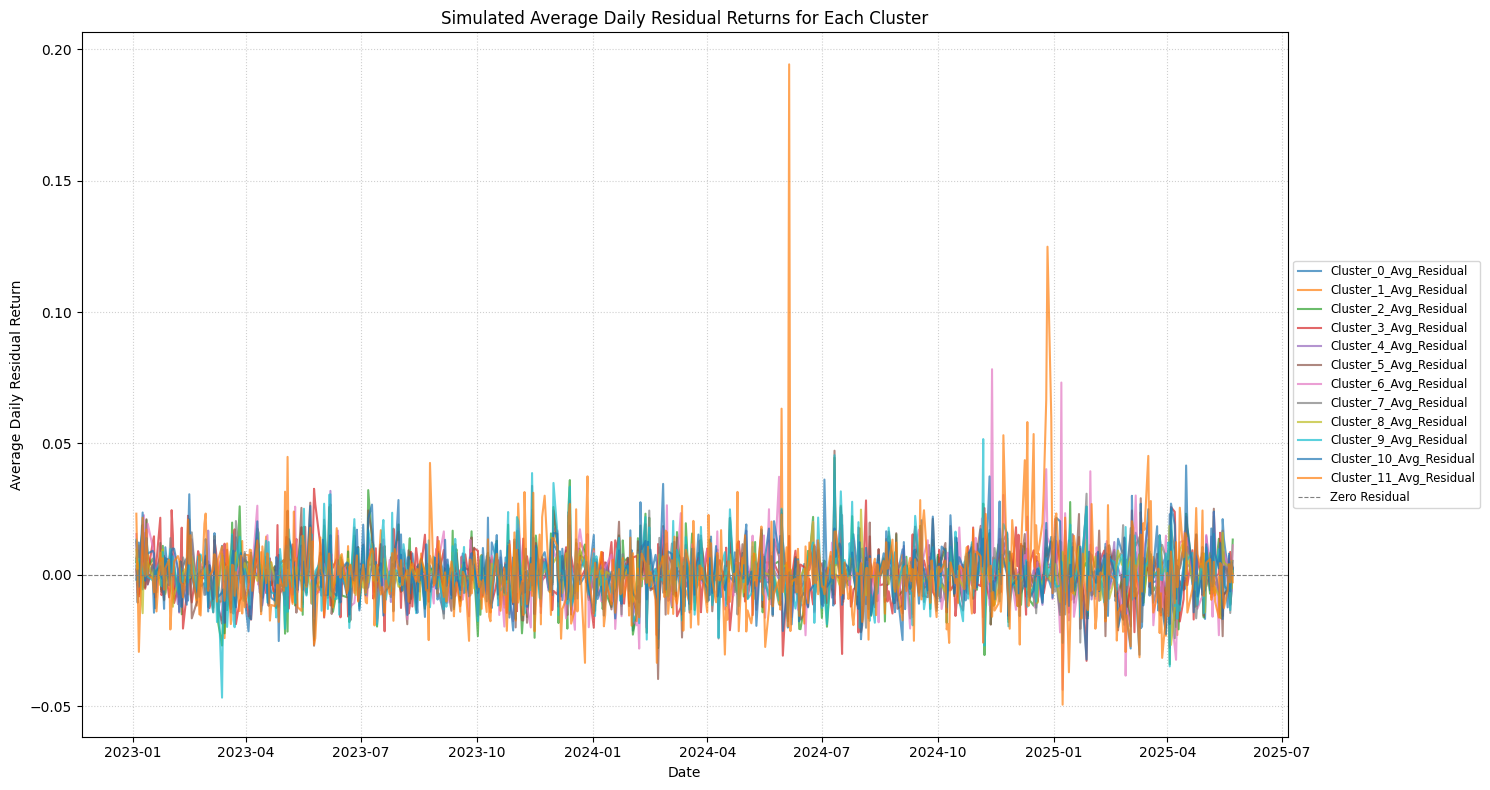

In [22]:
plt.figure(figsize=(15, 8))
for col in cluster_daily_avg_residuals.columns:
    plt.plot(cluster_daily_avg_residuals.index, cluster_daily_avg_residuals[col], label=col, alpha=0.7)

plt.title('Simulated Average Daily Residual Returns for Each Cluster')
plt.xlabel('Date')
plt.ylabel('Average Daily Residual Return')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8, label='Zero Residual')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
cluster_daily_avg_residuals.max()

Cluster_0_Avg_Residual     0.025906
Cluster_1_Avg_Residual     0.063227
Cluster_2_Avg_Residual     0.044551
Cluster_3_Avg_Residual     0.032713
Cluster_4_Avg_Residual     0.031918
Cluster_5_Avg_Residual     0.047221
Cluster_6_Avg_Residual     0.078250
Cluster_7_Avg_Residual     0.036251
Cluster_8_Avg_Residual     0.024787
Cluster_9_Avg_Residual     0.051644
Cluster_10_Avg_Residual    0.041590
Cluster_11_Avg_Residual    0.194341
dtype: float64

In [24]:
merged_tsne[merged_tsne['clusters'] == 11]

,Symbol,EM1,EM2,PC1,PC2,clusters,Sector,Name
3,ABAT,-3.984547,-37.281544,-1.044550,0.079195,11,Basic Materials,American Battery Technology Company Common Stock
11,ADSK,-8.144001,-33.581375,-0.888982,0.132062,11,Technology,Autodesk Inc. Common Stock
24,ALCE,-7.727063,-47.005367,-1.047981,0.653918,11,Utilities,Alternus Clean Energy Inc. Class A Common Stock
32,AMPGW,-11.410791,-36.656300,-0.945458,0.286593,11,Telecommunications,Amplitech Group Inc. Warrants
35,ANNA,-9.687331,-37.021248,-0.984048,0.236940,11,Energy,AleAnna Inc. Class A Common Stock
46,ASNS,-6.262572,-42.896389,-1.215073,0.326044,11,Telecommunications,Actelis Networks Inc. Common Stock
53,AXON,-0.587429,-34.712845,-0.991884,-0.129799,11,Industrials,Axon Enterprise Inc. Common Stock
58,BKNG,-0.867514,-38.552074,-1.217552,-0.016678,11,Consumer Discretionary,Booking Holdings Inc. Common Stock
64,BRFH,-10.718701,-35.564476,-0.925965,0.247407,11,Consumer Staples,Barfresh Food Group Inc. Common Stock
93,CLRO,-7.012303,-47.583313,-1.076540,0.629936,11,Utilities,ClearOne Inc. (DE) Common Stock


In [25]:
# Validating our thesis using Silhouette Score and Davies-Bouldin Index or Calinski-Harabasz Index
# Find the best cluster numbers by finding the optimal metrics

In [26]:
pc_scores = df_tsne.get(['PC1', 'PC2', 'Symbol']).set_index('Symbol')
sil_score = silhouette_score(pc_scores, tsne_clusters_aligned['cluster_label'])
dbi_score = davies_bouldin_score(pc_scores, tsne_clusters_aligned['cluster_label'])
chi_score = calinski_harabasz_score(pc_scores, tsne_clusters_aligned['cluster_label'])
print(sil_score, dbi_score, chi_score)

0.24598449476480078 1.0010208092504727 230.0040992218172


In [27]:
# run a for loop to find out the ideal number of clusters from 1 - 15
num_cluster = []
sil = []
dbi = []
chi = []

for i in range(2, 20):
    n_cluster = i
    print(f'Current cluster {i:}')
    pca_model = PCA(n_components=n_pca_component)
    pca_output = pca_model.fit_transform(resid_corr.values)
    tsne = TSNE(n_components=n_tsne_component, perplexity=15, init='random', random_state=42)
    embedding = tsne.fit_transform(pca_output)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)
    df_tsne = pd.DataFrame({
    'Symbol': ticker,
    'PC1': embedding[:,0],
    'PC2': embedding[:,1],
    'clusters': cluster_labels
    })
    pc_scores = df_tsne.get(['PC1', 'PC2', 'Symbol']).set_index('Symbol')
    corr_cluster = df_tsne['clusters']
    sil_score = silhouette_score(pc_scores, corr_cluster)
    dbi_score = davies_bouldin_score(pc_scores, corr_cluster)
    chi_score = calinski_harabasz_score(pc_scores, corr_cluster)
    print(sil_score, dbi_score, chi_score)
    num_cluster.append(i)
    dbi.append(dbi_score)
    chi.append(chi_score)
    sil.append(sil_score)

test_results = pd.DataFrame({
    'num_cluster': num_cluster,
    'sil': sil,
    'dbi': dbi,
    'chi': chi
    })
test_results
    

Current cluster 2
0.45647243 0.8266513838085595 589.2128
Current cluster 3
0.4577328 0.7736197887717601 575.43066
Current cluster 4
0.42126626 0.8441711348933854 615.6929
Current cluster 5
0.4334145 0.7311313612228807 629.82666
Current cluster 6
0.4098338 0.8512787706868529 589.6913
Current cluster 7
0.42054868 0.7389049917401697 623.9046
Current cluster 8
0.4155882 0.7750824699596146 635.77014
Current cluster 9
0.41470715 0.7424463644956703 660.42566
Current cluster 10
0.4194892 0.7750290093012167 699.48486
Current cluster 11
0.42266512 0.7728975642134356 702.9507
Current cluster 12
0.41998178 0.7604389996237454 721.054
Current cluster 13
0.44117916 0.7142833911253577 776.0896
Current cluster 14
0.45471668 0.6881442549144314 805.9181
Current cluster 15
0.45053473 0.7350366772038088 800.0206
Current cluster 16
0.44635049 0.7278068082912663 794.5867
Current cluster 17
0.46583217 0.6652061978036834 845.21497
Current cluster 18
0.4774971 0.6376930979265615 910.9052
Current cluster 19
0.47

,num_cluster,sil,dbi,chi
0,2,0.456472,0.826651,589.212830
1,3,0.457733,0.773620,575.430664
2,4,0.421266,0.844171,615.692871
3,5,0.433414,0.731131,629.826660
4,6,0.409834,0.851279,589.691284
5,7,0.420549,0.738905,623.904602
6,8,0.415588,0.775082,635.770142
7,9,0.414707,0.742446,660.425659
8,10,0.419489,0.775029,699.484863
9,11,0.422665,0.772898,702.950684


In [28]:
resid_corr

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
AAL,1.000000,0.064084,-0.016391,0.092678,0.199588,0.041715,0.123722,-0.030684,0.134636,-0.022283,...,0.030925,-0.019775,0.083275,0.207521,0.122848,-0.079557,0.088713,0.173428,0.036894,0.003225
AAON,0.064084,1.000000,-0.173120,0.027390,-0.048529,0.051398,0.122197,-0.076192,-0.003195,-0.005136,...,0.012505,0.045929,0.052346,0.106457,0.115454,0.001382,0.052251,0.094319,-0.016205,-0.010804
AAPL,-0.016391,-0.173120,1.000000,0.018873,0.014832,-0.047928,0.001233,-0.004365,0.024235,-0.031439,...,-0.007867,-0.072936,-0.023345,-0.040214,-0.026391,0.068185,-0.027380,-0.125070,0.028005,0.000231
ABAT,0.092678,0.027390,0.018873,1.000000,0.042258,0.022634,0.000992,-0.004634,0.023409,0.059555,...,-0.054659,-0.010287,0.054419,0.033473,0.055270,-0.001370,0.060346,0.029387,0.091082,0.014649
ABNB,0.199588,-0.048529,0.014832,0.042258,1.000000,-0.050847,0.022368,0.063440,0.147436,0.050426,...,0.104683,-0.019235,0.186032,0.147307,0.018543,0.032853,0.192724,0.092372,0.160946,0.089151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEO,-0.079557,0.001382,0.068185,-0.001370,0.032853,0.000922,-0.005202,0.039930,0.074191,0.042514,...,0.061825,-0.016128,0.042300,0.006893,-0.023811,1.000000,0.033847,0.029402,-0.002995,-0.005188
ZG,0.088713,0.052251,-0.027380,0.060346,0.192724,-0.038160,-0.015283,0.013877,-0.000909,0.128362,...,-0.013720,0.108534,0.994482,0.123648,0.145618,0.033847,1.000000,0.047933,0.132196,0.051532
ZION,0.173428,0.094319,-0.125070,0.029387,0.092372,0.224135,0.171665,-0.074212,-0.026668,0.114430,...,-0.077754,0.194482,0.048725,0.212057,0.209209,0.029402,0.047933,1.000000,0.013235,-0.031059
ZM,0.036894,-0.016205,0.028005,0.091082,0.160946,-0.004171,0.045787,0.124508,0.076264,0.068616,...,-0.027372,0.025046,0.127711,0.095134,0.159694,-0.002995,0.132196,0.013235,1.000000,0.300099


In [29]:
# bootstrap the sample to see if my cluster would change using a different sample size
optimal_n_pca_components = 6
optimal_tsne_output_dim = 2 
optimal_perplexity = 30            
optimal_n_clusters = 12


def run_clustering_pipeline(data_input, n_pca, tsne_dim, perp, n_clusters, random_seed_val):
    # Ensure data_input is a NumPy array for consistency
    data_input_arr = data_input.values if isinstance(data_input, pd.DataFrame) else data_input

    # PCA
    pca_model = PCA(n_components=n_pca, random_state=random_seed_val)
    pca_output = pca_model.fit_transform(data_input_arr)

    # t-SNE
    # Note: init='pca' is often more stable for t-SNE when using PCA output
    # Also, ensure learning_rate='auto' if sklearn version >= 1.0
    tsne_model = TSNE(n_components=tsne_dim, perplexity=perp, init='pca',
                      random_state=random_seed_val, learning_rate='auto', n_jobs=-1)
    embedding = tsne_model.fit_transform(pca_output)

    # KMeans
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_seed_val, n_init=10)
    cluster_labels = kmeans_model.fit_predict(embedding)

    return cluster_labels, embedding

In [30]:
from tqdm.notebook import tqdm
# define our parameter range (DONT RUN THIS CODE AGAIN TOOK 20 MIN)
# pca_n_components_range = list(range(2, 10, 1)) # Example range based on prior PCA analysis
# tsne_output_n_components_range = [2] # Usually 2 or 3 for t-SNE output
# perplexity_range = list(range(5, 50, 5)) # Example common perplexity values
# kmeans_n_clusters_range = list(range(8, 20, 1)) # Your range for optimal clusters
# bootstrap_time = list(range(10))
pca_n_components_range = list(range(2, 3, 1)) # Example range based on prior PCA analysis
tsne_output_n_components_range = [2] # Usually 2 or 3 for t-SNE output
perplexity_range = list(range(10, 16, 1)) # Example common perplexity values
kmeans_n_clusters_range = list(range(8, 16, 1)) # Your range for optimal clusters
bootstrap_time = list(range(10))

original_stock_indices = resid_corr.index # This is crucial for tracking samples
original_data_values = resid_corr.values

original_cluster_labels, original_embedding = run_clustering_pipeline(
    data_input=original_data_values,
    n_pca=optimal_n_pca_components,
    tsne_dim=optimal_tsne_output_dim,
    perp=optimal_perplexity,
    n_clusters=optimal_n_clusters,
    random_seed_val=42 
)

results_list = [] # To store results from each combination
for i in tqdm(bootstrap_time):

    bootstrap_indices_sampled = np.random.choice(
        original_stock_indices, # Choose from original indices
        size=len(original_stock_indices), # Same size as original
        replace=True # With replacement
    )

    bootstrap_data_values = resid_corr.loc[bootstrap_indices_sampled].values


    for pca_comp in tqdm(pca_n_components_range):
        pca_model = PCA(n_components=pca_comp, random_state=42)
        pca_output = pca_model.fit_transform(bootstrap_data_values)
        for tsne_dim in (tsne_output_n_components_range):
            for perp in (perplexity_range):
                try:
                    tsne_model = TSNE(n_components=tsne_dim, perplexity=perp, init='pca', random_state=42, learning_rate='auto', n_jobs=-1)
                    embedding = tsne_model.fit_transform(pca_output)
                except Exception as e:
                    print(f"    t-SNE failed for perp={perp}, dim={tsne_dim}: {e}. Skipping combination.")
                    continue # Skip to next iteration if t-SNE fails
                for k in (kmeans_n_clusters_range):

                    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
                    cluster_labels = kmeans_model.fit_predict(embedding)
                    sil = silhouette_score(embedding, cluster_labels)
                    dbi = davies_bouldin_score(embedding, cluster_labels)
                    chi = calinski_harabasz_score(embedding, cluster_labels)

                    results_list.append({
                        'n_pca': pca_comp,
                        'n_tsne_out_dim': tsne_dim,
                        'perplexity': perp,
                        'n_clusters': k,
                        'silhouette': sil,
                        'dbi': dbi,
                        'chi': chi,
                        'boot_samp_num': i,
                    })

results_df = pd.DataFrame(results_list)
results_df

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results_df.groupby(['n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).agg(['mean','std']).sort_values(by=[('silhouette', 'mean')], ascending=False)

NameError: name 'results_df' is not defined

In [ ]:
results_scores = results_df.groupby(['n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).agg(['mean','std'])
results_scores

NameError: name 'results_df' is not defined

In [ ]:
plt.scatter(results_scores.reset_index()['perplexity'], results_scores.reset_index()[('silhouette', 'mean')])

NameError: name 'results_scores' is not defined

In [ ]:
results_scores.sort_values(by=[('dbi', 'mean')], ascending=True).head(5)

NameError: name 'results_scores' is not defined

In [ ]:
results_scores.sort_values(by=[('chi', 'mean')], ascending=False).head(5)

NameError: name 'results_scores' is not defined

In [ ]:
results_scores

NameError: name 'results_scores' is not defined

In [ ]:
plt.scatter(results_scores.reset_index()['n_clusters'], results_scores[('chi', 'mean')])

NameError: name 'results_scores' is not defined

In [ ]:
plt.scatter(results_scores.reset_index()['n_clusters'], results_scores[('silhouette', 'mean')])

NameError: name 'results_scores' is not defined

In [ ]:
plt.scatter(results_scores.reset_index()['n_clusters'], results_scores[('dbi', 'mean')])

NameError: name 'results_scores' is not defined

In [ ]:
results_df.groupby(['boot_samp_num', 'n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).mean().sort_values(by='dbi', ascending=True).head(5)

NameError: name 'results_df' is not defined

In [ ]:
results_df.groupby(['boot_samp_num', 'n_pca', 'n_tsne_out_dim', 'perplexity', 'n_clusters']).mean().sort_values(by='chi', ascending=False).head(5)

NameError: name 'results_df' is not defined

In [ ]:
# Find the best combination based on Silhouette Score
best_silhouette = results_df.sort_values(by='silhouette', ascending=False).head(5)
print("\nTop 5 combinations by Silhouette Score:")
print(best_silhouette)

# Find the best combination based on Davies-Bouldin Index
best_dbi = results_df.sort_values(by='dbi', ascending=True).head(5)
print("\nTop 5 combinations by Davies-Bouldin Index:")
print(best_dbi)

NameError: name 'results_df' is not defined

In [ ]:
# Find the best combination based on Calinski-Harabasz Index
best_chi = results_df.sort_values(by='chi', ascending=False).head(5)
print("\nTop 5 combinations by Calinski-Harabasz Index:")
print(best_chi)

NameError: name 'results_df' is not defined

In [31]:
original_stock_indices = resid_corr.index # This is crucial for tracking samples
original_data_values = resid_corr.values

original_cluster_labels, original_embedding = run_clustering_pipeline(
    data_input=original_data_values,
    n_pca=optimal_n_pca_components,
    tsne_dim=optimal_tsne_output_dim,
    perp=optimal_perplexity,
    n_clusters=optimal_n_clusters,
    random_seed_val=42 
)

original_labels_series = pd.Series(original_cluster_labels, index=original_stock_indices)


num_bootstrap_iterations = 100 # A common number, increase for more robust results
bootstrap_ari_scores = []

for i in range(num_bootstrap_iterations):
    # Generate bootstrap sample indices (sampling with replacement)
    # We sample the *indices* of the original data to preserve identity
    bootstrap_indices_sampled = np.random.choice(
        original_stock_indices, # Choose from original indices
        size=len(original_stock_indices), # Same size as original
        replace=True # With replacement
    )

    # Create the bootstrap data (use .loc if original is DataFrame, direct indexing if NumPy array)
    # This creates a new matrix with some rows duplicated and some omitted.
    bootstrap_data_values = resid_corr.loc[bootstrap_indices_sampled].values
    # Note: The order of rows in bootstrap_data_values corresponds to bootstrap_indices_sampled

    # Run the clustering pipeline on the bootstrap sample
    # IMPORTANT: Use a consistent random_state for reproducibility within each bootstrap run,
    # or vary it if you want to test sensitivity to algorithmic randomness too.
    # Keeping it fixed (e.g., i for each iter) is usually good for stability testing.
    bootstrap_labels, _ = run_clustering_pipeline(
        data_input=bootstrap_data_values,
        n_pca=optimal_n_pca_components,
        tsne_dim=optimal_tsne_output_dim,
        perp=optimal_perplexity,
        n_clusters=optimal_n_clusters,
        random_seed_val=i # Vary random state per iteration
    )
    # Store bootstrap labels with their corresponding indices (from bootstrap_indices_sampled)
    bootstrap_labels_series = pd.Series(bootstrap_labels, index=bootstrap_indices_sampled)

    # --- Align samples for comparison ---
    # Find stocks that are present in both the original and this bootstrap sample
    # Note: A stock can appear multiple times in bootstrap_labels_series due to replacement.
    # We need to ensure we compare based on unique original identities.

    # Get unique original stock IDs that appear in this bootstrap sample
    unique_original_stocks_in_bootstrap = bootstrap_labels_series.index.unique()

    # Filter for common stocks between original and this bootstrap sample
    common_stocks = original_labels_series.index.intersection(unique_original_stocks_in_bootstrap)

    if len(common_stocks) > 1: # Need at least 2 common samples for ARI
        # Get the reference labels for only these common stocks
        ref_labels_for_ari = original_labels_series.loc[common_stocks]

        # Get the bootstrap labels for these common stocks.
        # If a stock was duplicated in bootstrap_indices_sampled, its label will appear multiple times.
        # We need to take a single label for each unique common stock from the bootstrap result.
        # A common way is to take the mode (most frequent label) if a stock appears multiple times,
        # or just the first one if we assume consistency. For simplicity, let's align by index
        # and ensure unique indices for comparison.

        # Create a Series of labels for common stocks from the bootstrap result.
        # This requires careful re-indexing if bootstrap_labels_series has duplicates.
        # A robust way is to re-run the pipeline on *just the unique common stocks*
        # if cluster labels must be exactly from one run, or average.
        # More commonly for ARI, we just use the first instance's label if duplicates exist in bootstrap.
        # Simpler approach: Map the labels back to original common_stocks order

        # To handle duplicates in bootstrap_labels_series (from `np.random.choice(..., replace=True)`):
        # For ARI, we need a single label for each unique sample.
        # If a stock appears multiple times in the bootstrap sample, it will have multiple labels.
        # The most straightforward way is to take the *first* label assigned to it if it was duplicated,
        # OR consider only unique stocks that appeared in the bootstrap sample.

        # Let's align by getting the unique indices of the bootstrap sample, then intersect with original.
        # And take the first label for each unique stock in the bootstrap result.
        aligned_bootstrap_labels = bootstrap_labels_series.groupby(level=0).first().loc[common_stocks] # Get first label for each unique stock

        # Calculate ARI
        ari_score = adjusted_rand_score(ref_labels_for_ari, aligned_bootstrap_labels)
        bootstrap_ari_scores.append(ari_score)
    else:
        print(f"  Iteration {i+1}: Not enough common samples ({len(common_stocks)}) for ARI calculation. Skipping.")

    if (i + 1) % 10 == 0:
        print(f"  Iteration {i+1} complete. Current mean ARI: {np.mean(bootstrap_ari_scores):.4f}")

print("\nBootstrap analysis complete.")

# --- 4. Analyze Results ---
if bootstrap_ari_scores:
    mean_ari = np.mean(bootstrap_ari_scores)
    std_ari = np.std(bootstrap_ari_scores)
    min_ari = np.min(bootstrap_ari_scores)
    max_ari = np.max(bootstrap_ari_scores)

    print(f"\n--- Bootstrap Clustering Stability Results (n={num_bootstrap_iterations} iterations) ---")
    print(f"Mean Adjusted Rand Index (ARI): {mean_ari:.4f}")
    print(f"Standard Deviation of ARI:      {std_ari:.4f}")
    print(f"Minimum ARI:                    {min_ari:.4f}")
    print(f"Maximum ARI:                    {max_ari:.4f}")

    plt.figure(figsize=(8, 5))
    plt.hist(bootstrap_ari_scores, bins=15, edgecolor='black', alpha=0.7)
    plt.axvline(mean_ari, color='red', linestyle='dashed', linewidth=1, label=f'Mean ARI: {mean_ari:.4f}')
    plt.title('Distribution of Adjusted Rand Index Scores from Bootstrapping')
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Interpretation:
    if mean_ari > 0.8:
        print("Interpretation: Very strong clustering stability. Clusters are highly robust to sampling variations.")
    elif mean_ari > 0.6:
        print("Interpretation: Good clustering stability. Clusters are reasonably robust.")
    elif mean_ari > 0.4:
        print("Interpretation: Moderate clustering stability. Clusters show some sensitivity to sampling.")
    else:
        print("Interpretation: Low clustering stability. Clusters are highly dependent on the specific sample.")

else:
    print("No ARI scores were calculated. Check common sample filtering.")


  Iteration 10 complete. Current mean ARI: 0.5217
  Iteration 20 complete. Current mean ARI: 0.5241


KeyboardInterrupt: 

In [32]:
# --- Helper Function: The Clustering & Selection Pipeline ---
# This function remains mostly the same as in the previous code,
# encapsulating the steps that run at each rebalancing point.
def _get_long_short_stocks_for_window(
    current_residuals_window_data, # DataFrame of residuals for the lookback window (dates x stocks)
    optimal_n_pca, optimal_tsne_dim, optimal_perp, optimal_n_clusters,
    num_top_clusters, num_bottom_clusters, proportion_to_invest, random_seed_val # Changed parameters
):
    # Ensure data is sufficient for clustering.
    pca_input_data = current_residuals_window_data.T # (stocks x days)
    n_samples_pca = pca_input_data.shape[0] # Number of stocks
    n_features_pca = pca_input_data.shape[1] # Number of days in window

    if n_samples_pca < 2 or n_features_pca < 2:
        return [], [] # Not enough stocks or days for meaningful clustering

    # Adjust n_pca_components if window size is too small for PCA
    actual_n_pca = min(optimal_n_pca, n_features_pca -1)
    if actual_n_pca < 1: return [], []

    # Adjust perplexity if window size is too small for t-SNE
    actual_perp = min(optimal_perp, n_samples_pca - 1)
    if actual_perp < 2: actual_perp = 2 # Perplexity must be >= 2

    # Adjust n_clusters if number of stocks in window is too small for KMeans
    n_clusters_for_kmeans_window = min(optimal_n_clusters, n_samples_pca)
    if n_clusters_for_kmeans_window < 2: n_clusters_for_kmeans_window = 2
    
    # --- Clustering Pipeline ---
    try:
        # PCA
        pca_model = PCA(n_components=actual_n_pca, random_state=random_seed_val)
        pca_output = pca_model.fit_transform(pca_input_data)

        # t-SNE
        tsne_model = TSNE(n_components=optimal_tsne_dim, perplexity=actual_perp,
                          init='pca', random_state=random_seed_val, learning_rate='auto', n_jobs=-1)
        embedding = tsne_model.fit_transform(pca_output)

        # KMeans
        kmeans_model = KMeans(n_clusters=n_clusters_for_kmeans_window, random_state=random_seed_val, n_init=10)
        cluster_labels = kmeans_model.fit_predict(embedding)

        # Create stock_to_cluster_map for this window
        stock_to_cluster_map = pd.Series(cluster_labels, index=current_residuals_window_data.columns)
        stock_to_cluster_map.name = 'Cluster_Label'

        # --- Stock Selection within Clusters ---
        individual_stock_avg_residuals_window = current_residuals_window_data.mean()
        individual_stock_avg_residuals_window.name = 'Avg_Residual_Return'

        cluster_daily_avg_residuals_window_df = pd.DataFrame()
        for cl_label in sorted(stock_to_cluster_map.unique()):
            stocks_in_cl = stock_to_cluster_map[stock_to_cluster_map == cl_label].index.tolist()
            if stocks_in_cl:
                cluster_daily_avg_residuals_window_df[f'Cluster_{cl_label}_Avg_Residual'] = \
                    current_residuals_window_data[stocks_in_cl].mean(axis=1)
        
        if cluster_daily_avg_residuals_window_df.empty: return [], []
        
        overall_average_residuals_clusters_window = cluster_daily_avg_residuals_window_df.mean()

        # --- Adjusted Cluster Selection Logic ---
        # Ensure we don't try to pick more clusters than available
        available_clusters = len(overall_average_residuals_clusters_window)
        
        actual_num_top_clusters = min(num_top_clusters, available_clusters // 2)
        actual_num_bottom_clusters = min(num_bottom_clusters, available_clusters - actual_num_top_clusters) # Remaining for bottom

        if actual_num_top_clusters == 0 and actual_num_bottom_clusters == 0:
            return [], [] # No clusters to pick from

        sorted_clusters = overall_average_residuals_clusters_window.sort_values(ascending=False)
        
        # Select top clusters for longing
        top_filter = sorted_clusters[sorted_clusters.values > 0]
        print(top_filter)
        overperformer_cluster_ids = [int(name.split('_')[1]) for name in top_filter.head(actual_num_top_clusters).index.tolist()]
        
        # Select bottom clusters for shorting
        # Ensure we don't overlap with top clusters if available_clusters is small
        bot_filter = sorted_clusters[sorted_clusters.values < 0]
        print(bot_filter)
        bottom_clusters_candidates = bot_filter.tail(available_clusters - actual_num_top_clusters)
        underperformer_cluster_ids = [int(name.split('_')[1]) for name in bottom_clusters_candidates.head(actual_num_bottom_clusters).index.tolist()]


        final_long_stocks = []
        final_short_stocks = []

        stock_details_window = stock_to_cluster_map.to_frame().join(individual_stock_avg_residuals_window, how='inner')

        # Process Underperforming Clusters (for Short Positions)
        for cluster_id in underperformer_cluster_ids:
            stocks_in_cl = stock_details_window[stock_details_window['Cluster_Label'] == cluster_id]
            ranked_stocks = stocks_in_cl.sort_values(by='Avg_Residual_Return', ascending=False)
            num_to_select = int(len(ranked_stocks) * proportion_to_invest)
            if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
            final_long_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())
            final_short_stocks.extend(ranked_stocks.tail(num_to_select).index.tolist())

        # Process Overperforming Clusters (for Long Positions)
        for cluster_id in overperformer_cluster_ids:
            stocks_in_cl = stock_details_window[stock_details_window['Cluster_Label'] == cluster_id]
            ranked_stocks = stocks_in_cl.sort_values(by='Avg_Residual_Return', ascending=True)
            num_to_select = int(len(ranked_stocks) * proportion_to_invest)
            if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
            final_short_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())
            final_long_stocks.extend(ranked_stocks.tail(num_to_select).index.tolist())
            
        # Ensure selected stocks actually have data in the current window for the next period (for safety)
        available_stocks_next_period = current_residuals_window_data.columns.tolist() # Assuming all stocks in window are available
        final_long_stocks = [s for s in final_long_stocks if s in available_stocks_next_period]
        final_short_stocks = [s for s in final_short_stocks if s in available_stocks_next_period]

        return final_long_stocks, final_short_stocks

    except Exception as e:
        # print(f"  Warning: Clustering/Selection failed for window ({e}). Returning empty lists.")
        return [], [] # Return empty lists if any part of the pipeline fails

# --- Main Simulation Function ---
def simulate_rebalancing_portfolio(
    residuals: pd.DataFrame,
    stock_returns: pd.DataFrame,
    
    # Optimal Hyperparameters for PCA -> t-SNE -> KMeans
    optimal_n_pca_components: int,
    optimal_tsne_output_dim: int,
    optimal_perplexity: int,
    optimal_n_clusters: int,
    
    # Simulation Parameters
    lookback_window_days: int,
    rebalance_frequency_days: int,
    num_top_clusters: int, # NEW: Number of top clusters for shorting
    num_bottom_clusters: int, # NEW: Number of bottom clusters for longing
    proportion_to_invest: float,
    initial_capital: float,
    
    # Performance Metrics Parameters
    risk_free_rate_annual: float = 0.02,
    num_trading_days_in_year: int = 252,
    verbose: bool = True
) -> (pd.Series, dict):

    # --- 1. Data Alignment and Preparation ---
    common_dates = residuals.index.intersection(stock_returns.index)
    common_stocks = residuals.columns.intersection(stock_returns.columns)

    residuals = residuals.loc[common_dates, common_stocks].copy()
    stock_returns = stock_returns.loc[common_dates, common_stocks].copy()

    all_dates = residuals.index
    num_full_days = len(all_dates)
    num_stocks = len(common_stocks)

    if verbose:
        print("--- Starting Portfolio Simulation ---")
        print(f"Full data period: {all_dates.min().strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"Total stocks available: {num_stocks}")
        print(f"Clustering config: PCA={optimal_n_pca_components}, tSNE_dim={optimal_tsne_output_dim}, Perp={optimal_perplexity}, K={optimal_n_clusters}")
        print(f"Strategy config: Lookback={lookback_window_days}d, Rebalance={rebalance_frequency_days}d, Top={num_top_clusters}, Bottom={num_bottom_clusters}, Invest_Prop={proportion_to_invest*100:.0f}%")
        print("-" * 60)

    # --- 2. Determine Rebalancing Dates ---
    first_rebalance_idx = all_dates.get_loc(all_dates[0]) + lookback_window_days
    
    if first_rebalance_idx >= num_full_days:
        if verbose: print("Error: Not enough historical data for even the first lookback window. Adjust 'lookback_window_days' or data range.")
        return pd.Series(), {}

    rebalance_dates_indices = np.arange(first_rebalance_idx, num_full_days, rebalance_frequency_days)
    rebalance_dates = all_dates[rebalance_dates_indices].tolist()

    if verbose:
        print(f"Simulation will run from {all_dates[first_rebalance_idx].strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"First rebalance on: {rebalance_dates[0].strftime('%Y-%m-%d')}")
        print(f"Last rebalance on: {rebalance_dates[-1].strftime('%Y-%m-%d')}")
        print("-" * 60)

    # --- 3. Initialize Portfolio Tracking ---
    portfolio_daily_returns_list = []
    portfolio_values_history = [initial_capital]
    current_portfolio_value = initial_capital

    current_long_stocks = []
    current_short_stocks = []
    
    # --- 4. Main Simulation Loop ---
    for i in range(first_rebalance_idx, num_full_days):
        current_date = all_dates[i]
        
        # --- Check for Rebalancing ---
        if current_date in rebalance_dates:
            if verbose: print(f"\n--- Rebalancing on: {current_date.strftime('%Y-%m-%d')} ---")
            
            # Define the lookback window for this rebalance
            window_start_date_idx = all_dates.get_loc(current_date) - lookback_window_days
            window_start_date = all_dates[max(0, window_start_date_idx)]

            current_residuals_window = residuals.loc[window_start_date:current_date].copy()
            current_residuals_window = current_residuals_window.dropna(axis=1, how='all')

            # Run the clustering and selection pipeline
            new_long_stocks, new_short_stocks = _get_long_short_stocks_for_window(
                current_residuals_window_data=current_residuals_window,
                optimal_n_pca=optimal_n_pca_components,
                optimal_tsne_dim=optimal_tsne_output_dim,
                optimal_perp=optimal_perplexity,
                optimal_n_clusters=optimal_n_clusters,
                num_top_clusters=num_top_clusters, # Passed separately
                num_bottom_clusters=num_bottom_clusters, # Passed separately
                proportion_to_invest=proportion_to_invest,
                random_seed_val=i
            )
            
            # Update current positions
            current_long_stocks = new_long_stocks
            current_short_stocks = new_short_stocks
            
            if verbose: print(f"  Longing {len(current_long_stocks)} stocks and Shorting {len(current_short_stocks)} stocks.")
            
        # --- Calculate Daily Portfolio Return ---
        daily_portfolio_return = 0.0
        
        if current_long_stocks or current_short_stocks:
            today_returns = stock_returns.loc[current_date]
            
            if current_long_stocks:
                long_weight_per_stock = 1 / len(current_long_stocks)
                for stock_ticker in current_long_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return += today_returns.loc[stock_ticker] * long_weight_per_stock
            
            if current_short_stocks:
                short_weight_per_stock = 1 / len(current_short_stocks)
                for stock_ticker in current_short_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return -= today_returns.loc[stock_ticker] * short_weight_per_stock

        portfolio_daily_returns_list.append(daily_portfolio_return)
        current_portfolio_value *= (1 + daily_portfolio_return)
        portfolio_values_history.append(current_portfolio_value)

    if verbose: print("\n--- Simulation Complete ---")

    # --- 5. Final Analysis and Return ---
    portfolio_daily_returns_series = pd.Series(portfolio_daily_returns_list, index=all_dates[first_rebalance_idx:])
    cumulative_portfolio_returns = (1 + portfolio_daily_returns_series).cumprod() - 1

    annualized_return = (1 + portfolio_daily_returns_series.mean())**num_trading_days_in_year - 1
    annualized_volatility = portfolio_daily_returns_series.std() * np.sqrt(num_trading_days_in_year)
    
    sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_volatility if annualized_volatility != 0 else np.nan

    performance_metrics = {
        'total_return': cumulative_portfolio_returns.iloc[-1],
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'portfolio_value_history': pd.Series(portfolio_values_history, index=all_dates[first_rebalance_idx-1:]),
        'daily_returns_series': portfolio_daily_returns_series
    }

    if verbose:
        print("\n--- Portfolio Performance Metrics ---")
        print(f"Total Portfolio Return: {performance_metrics['total_return']:.4f}")
        print(f"Annualized Portfolio Return: {performance_metrics['annualized_return']:.4f}")
        print(f"Annualized Portfolio Volatility: {performance_metrics['annualized_volatility']:.4f}")
        print(f"Sharpe Ratio (assuming {risk_free_rate_annual*100:.1f}% risk-free rate): {performance_metrics['sharpe_ratio']:.4f}")
        print("-" * 60)

    return cumulative_portfolio_returns, performance_metrics

In [33]:
my_optimal_pca_components = 2
my_optimal_tsne_output_dim = 2 
my_optimal_perplexity = 15
my_optimal_n_clusters = 12

my_lookback_window_days = 20
my_rebalance_frequency_days = 5
my_num_top_clusters = 2
my_num_bottom_clusters = 1
my_proportion_to_invest = 0.5
my_initial_capital = 100000



cumulative_returns, performance_metrics = simulate_rebalancing_portfolio(
    residuals=residuals, # Your actual residuals DataFrame
    stock_returns=stock_returns, # Your actual stock_returns DataFrame
    
    optimal_n_pca_components=my_optimal_pca_components,
    optimal_tsne_output_dim=my_optimal_tsne_output_dim,
    optimal_perplexity=my_optimal_perplexity,
    optimal_n_clusters=my_optimal_n_clusters,
    
    lookback_window_days=my_lookback_window_days,
    rebalance_frequency_days=my_rebalance_frequency_days,
    num_top_clusters=my_num_top_clusters,
    num_bottom_clusters=my_num_bottom_clusters,
    proportion_to_invest=my_proportion_to_invest,
    initial_capital=my_initial_capital,
    
    verbose=True # Set to False to suppress print statements during simulation
)

--- Starting Portfolio Simulation ---
Full data period: 2023-01-04 to 2025-05-23
Total stocks available: 485
Clustering config: PCA=2, tSNE_dim=2, Perp=15, K=12
Strategy config: Lookback=20d, Rebalance=5d, Top=2, Bottom=1, Invest_Prop=50%
------------------------------------------------------------
Simulation will run from 2023-02-02 to 2025-05-23
First rebalance on: 2023-02-02
Last rebalance on: 2025-05-20
------------------------------------------------------------

--- Rebalancing on: 2023-02-02 ---
Cluster_0_Avg_Residual    0.014952
Cluster_7_Avg_Residual    0.007162
Cluster_9_Avg_Residual    0.005585
Cluster_3_Avg_Residual    0.003793
Cluster_8_Avg_Residual    0.003137
Cluster_6_Avg_Residual    0.002510
Cluster_4_Avg_Residual    0.002456
Cluster_2_Avg_Residual    0.000691
dtype: float64
Cluster_10_Avg_Residual   -0.000167
Cluster_11_Avg_Residual   -0.000178
Cluster_1_Avg_Residual    -0.002494
Cluster_5_Avg_Residual    -0.003018
dtype: float64
  Longing 56 stocks and Shorting 56 st

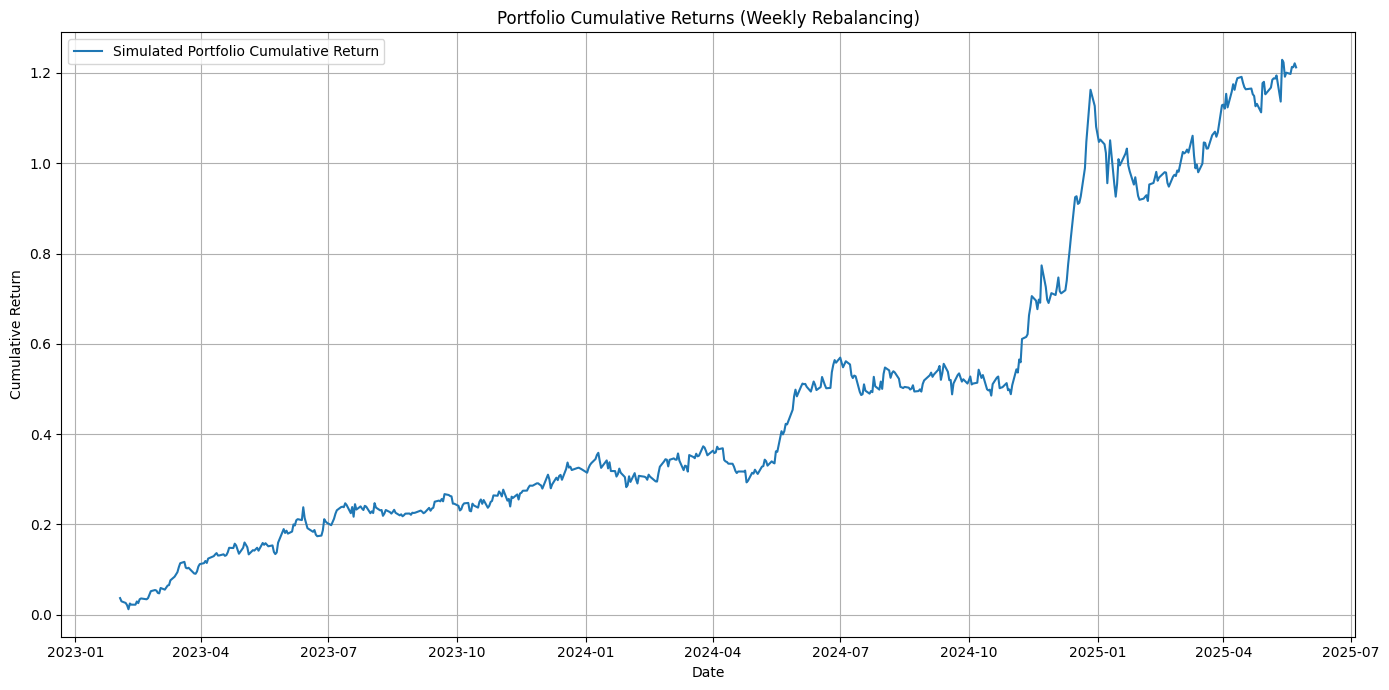

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='Simulated Portfolio Cumulative Return')
plt.title('Portfolio Cumulative Returns (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

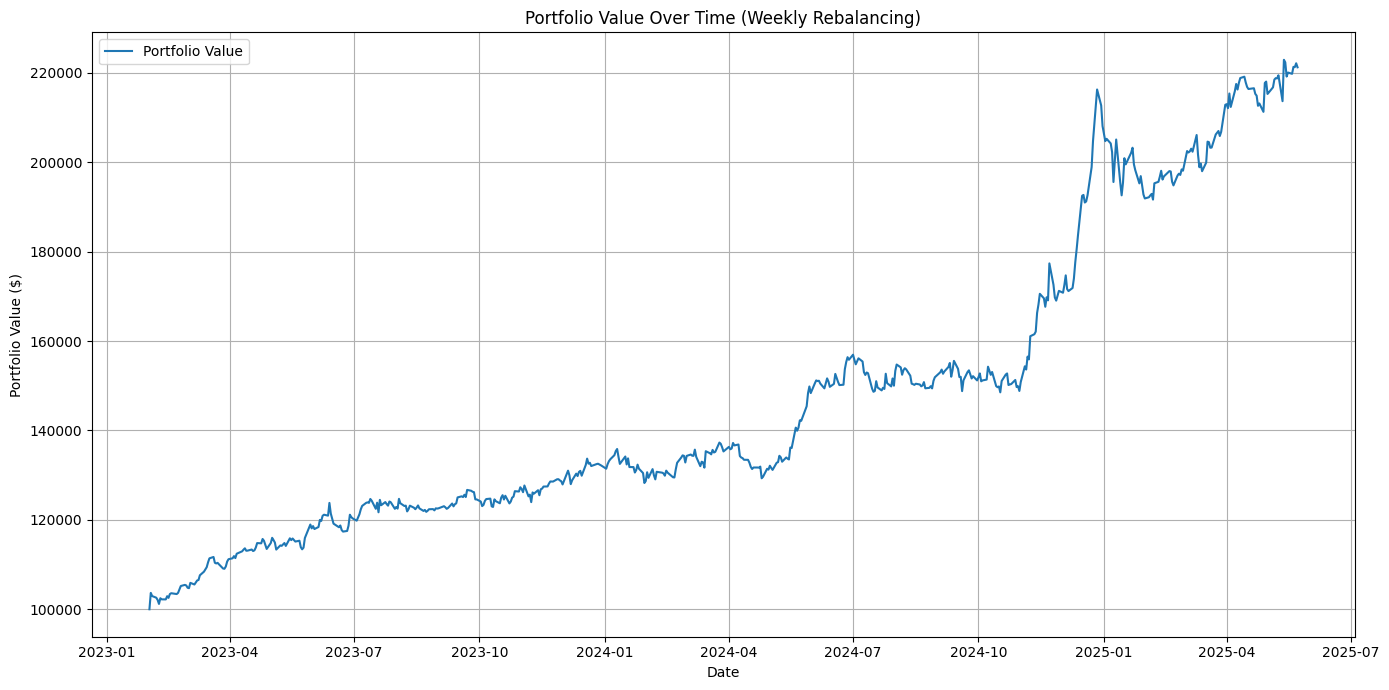

In [35]:
plt.figure(figsize=(14, 7))
# Use 'portfolio_value_history' from the performance_metrics dictionary
plt.plot(performance_metrics['portfolio_value_history'].index, performance_metrics['portfolio_value_history'].values, label='Portfolio Value')
plt.title('Portfolio Value Over Time (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [36]:
market_returns

Date
2023-01-04    0.007539
2023-01-05   -0.011646
2023-01-06    0.022841
2023-01-09   -0.000768
2023-01-10    0.006978
                ...   
2025-05-19    0.000876
2025-05-20   -0.003880
2025-05-21   -0.016135
2025-05-22   -0.000445
2025-05-23   -0.006708
Name: ^GSPC, Length: 599, dtype: float64

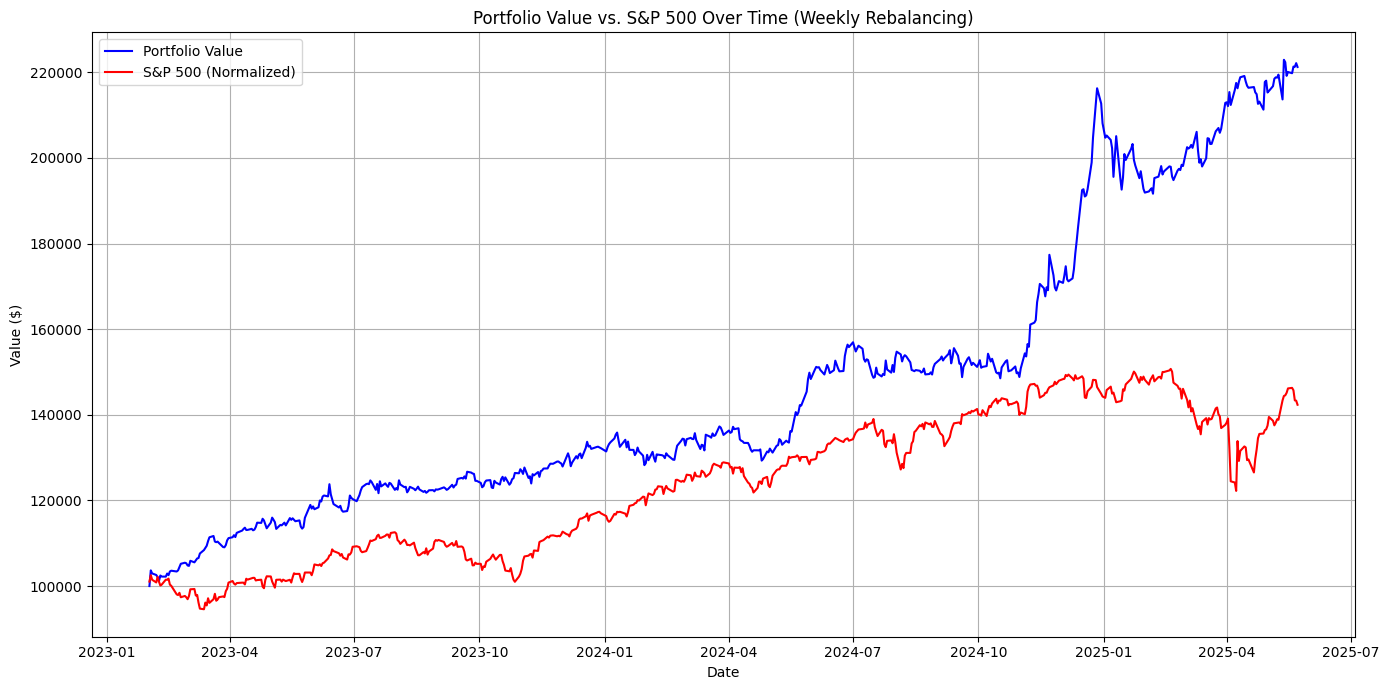

In [37]:
market_returns_aligned_to_portfolio = market_returns.reindex(
    performance_metrics['portfolio_value_history'].index, method='ffill'
)

market_returns_aligned_to_portfolio = market_returns_aligned_to_portfolio.dropna()

market_portfolio_values = my_initial_capital * (1 + market_returns_aligned_to_portfolio).cumprod()

common_index = performance_metrics['portfolio_value_history'].index.intersection(market_portfolio_values.index)

portfolio_value_aligned = performance_metrics['portfolio_value_history'].loc[common_index]
sp500_normalized_value_aligned = market_portfolio_values.loc[common_index]

plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.plot(portfolio_value_aligned.index, portfolio_value_aligned.values, label='Portfolio Value', color='blue')

# Overlay S&P 500 Return
plt.plot(sp500_normalized_value_aligned.index, sp500_normalized_value_aligned.values, label='S&P 500 (Normalized)', color='red')

plt.title('Portfolio Value vs. S&P 500 Over Time (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [38]:
# Sector based clustering and investing

In [ ]:
# --- Helper Function: Get Long/Short Stocks by Sector ---
# This function is analogous to _get_long_short_stocks_for_window but for sectors.
def _get_long_short_stocks_by_sector_for_window(
    current_residuals_window_data: pd.DataFrame, # Residuals for the lookback window
    stock_sectors_map: pd.Series,              # Map of stock -> sector
    num_top_sectors: int,                      # How many top sectors to short
    num_bottom_sectors: int,                   # How many bottom sectors to long
    proportion_to_invest: float                # Proportion of stocks within selected sectors
) -> (list, list):

    # Ensure stock_sectors_map aligns with stocks in current_residuals_window_data
    available_stocks_in_window = current_residuals_window_data.columns
    aligned_stock_sectors_map = stock_sectors_map.loc[available_stocks_in_window].dropna()

    if aligned_stock_sectors_map.empty:
        return [], [] # No stocks with sector data in this window

    # 1. Calculate Individual Stock Average Residual Returns for this window
    individual_stock_avg_residuals_window = current_residuals_window_data.mean()
    individual_stock_avg_residuals_window.name = 'Avg_Residual_Return'

    # 2. Combine individual stock residuals with their sectors
    stock_details_window = aligned_stock_sectors_map.to_frame().join(
        individual_stock_avg_residuals_window, how='inner'
    )
    
    # 3. Calculate Average Residual Return for Each Sector
    sector_avg_residuals = stock_details_window.groupby('Sector')['Avg_Residual_Return'].mean()

    # 4. Identify Top/Bottom Sectors
    available_sectors = len(sector_avg_residuals)
    actual_num_top_sectors = min(num_top_sectors, available_sectors // 2)
    actual_num_bottom_sectors = min(num_bottom_sectors, available_sectors - actual_num_top_sectors)

    if actual_num_top_sectors == 0 and actual_num_bottom_sectors == 0:
        return [], []

    sorted_sectors = sector_avg_residuals.sort_values(ascending=False)

    filtered_overperformer = sorted_sectors[sorted_sectors.values > 0]
    filtered_underperformer = sorted_sectors[sorted_sectors.values < 0]

    overperformer_sector_names = filtered_overperformer.head(actual_num_top_sectors).index.tolist()
    underperformer_sector_names = filtered_underperformer.tail(actual_num_bottom_sectors).index.tolist()


    final_long_stocks = []
    final_short_stocks = []

    # 5. Select Proportion of Stocks *Within* Identified Sectors
    # Process consistently bad Sectors (for short Positions)
    for sector_name in underperformer_sector_names:
        stocks_in_this_sector = stock_details_window[stock_details_window['Sector'] == sector_name]
        ranked_stocks = stocks_in_this_sector.sort_values(by='Avg_Residual_Return', ascending=False) # Longing best within good sector
        num_to_select = int(len(ranked_stocks) * proportion_to_invest)
        if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
        final_long_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())
        final_short_stocks.extend(ranked_stocks.tail(num_to_select).index.tolist())

    # Process consistently good Sectors (for long Positions)
    for sector_name in overperformer_sector_names:
        stocks_in_this_sector = stock_details_window[stock_details_window['Sector'] == sector_name]
        ranked_stocks = stocks_in_this_sector.sort_values(by='Avg_Residual_Return', ascending=True) # Shorting worst within bad sector
        num_to_select = int(len(ranked_stocks) * proportion_to_invest)
        if num_to_select == 0 and len(ranked_stocks) > 0: num_to_select = 1
        final_short_stocks.extend(ranked_stocks.head(num_to_select).index.tolist())
        final_long_stocks.extend(ranked_stocks.tail(num_to_select).index.tolist())
        
    return final_long_stocks, final_short_stocks


# --- Main Simulation Function for Sector-Based Strategy ---
def simulate_sector_based_portfolio(
    residuals: pd.DataFrame,
    stock_returns: pd.DataFrame,
    stock_sectors_df: pd.DataFrame, # NEW: DataFrame with stock sectors
    
    # Simulation Parameters (similar to cluster-based)
    lookback_window_days: int,
    rebalance_frequency_days: int,
    num_top_sectors: int,          # NEW: Number of top sectors to short
    num_bottom_sectors: int,       # NEW: Number of bottom sectors to long
    proportion_to_invest: float,
    initial_capital: float,
    
    # Performance Metrics Parameters
    risk_free_rate_annual: float = 0.02,
    num_trading_days_in_year: int = 252,
    verbose: bool = True
) -> (pd.Series, dict):

    # --- 1. Data Alignment and Preparation ---
    # Ensure all three inputs (residuals, stock_returns, stock_sectors_df) are aligned
    common_dates = residuals.index.intersection(stock_returns.index)
    common_stocks = residuals.columns.intersection(stock_returns.columns).intersection(stock_sectors_df.index)

    residuals = residuals.loc[common_dates, common_stocks].copy()
    stock_returns = stock_returns.loc[common_dates, common_stocks].copy()
    stock_sectors_map = stock_sectors_df.loc[common_stocks, 'Sector'].copy() # Ensure it's a Series with 'Sector' column

    all_dates = residuals.index
    num_full_days = len(all_dates)
    num_stocks = len(common_stocks)

    if verbose:
        print("--- Starting Sector-Based Portfolio Simulation ---")
        print(f"Full data period: {all_dates.min().strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"Total stocks available: {num_stocks}")
        print(f"Strategy config: Lookback={lookback_window_days}d, Rebalance={rebalance_frequency_days}d, Top Sectors={num_top_sectors}, Bottom Sectors={num_bottom_sectors}, Invest_Prop={proportion_to_invest*100:.0f}%")
        print("-" * 60)

    # --- 2. Determine Rebalancing Dates ---
    first_rebalance_idx = all_dates.get_loc(all_dates[0]) + lookback_window_days
    
    if first_rebalance_idx >= num_full_days:
        if verbose: print("Error: Not enough historical data for even the first lookback window. Adjust 'lookback_window_days' or data range.")
        return pd.Series(), {}

    rebalance_dates_indices = np.arange(first_rebalance_idx, num_full_days, rebalance_frequency_days)
    rebalance_dates = all_dates[rebalance_dates_indices].tolist()

    if verbose:
        print(f"Simulation will run from {all_dates[first_rebalance_idx].strftime('%Y-%m-%d')} to {all_dates.max().strftime('%Y-%m-%d')}")
        print(f"First rebalance on: {rebalance_dates[0].strftime('%Y-%m-%d')}")
        print(f"Last rebalance on: {rebalance_dates[-1].strftime('%Y-%m-%d')}")
        print("-" * 60)

    # --- 3. Initialize Portfolio Tracking ---
    portfolio_daily_returns_list = []
    portfolio_values_history = [initial_capital]
    current_portfolio_value = initial_capital

    current_long_stocks = []
    current_short_stocks = []
    
    # --- 4. Main Simulation Loop ---
    for i in range(first_rebalance_idx, num_full_days):
        current_date = all_dates[i]
        
        # --- Check for Rebalancing ---
        if current_date in rebalance_dates:
            if verbose: print(f"\n--- Rebalancing on: {current_date.strftime('%Y-%m-%d')} ---")
            
            # Define the lookback window for this rebalance
            window_start_date_idx = all_dates.get_loc(current_date) - lookback_window_days
            window_start_date = all_dates[max(0, window_start_date_idx)]

            current_residuals_window = residuals.loc[window_start_date:current_date].copy()
            current_residuals_window = current_residuals_window.dropna(axis=1, how='all')

            # Run the sector-based selection pipeline
            new_long_stocks, new_short_stocks = _get_long_short_stocks_by_sector_for_window(
                current_residuals_window_data=current_residuals_window,
                stock_sectors_map=stock_sectors_map,
                num_top_sectors=num_top_sectors,
                num_bottom_sectors=num_bottom_sectors,
                proportion_to_invest=proportion_to_invest
            )
            
            # Update current positions
            current_long_stocks = new_long_stocks
            current_short_stocks = new_short_stocks
            
            if verbose: print(f"  Longing {len(current_long_stocks)} stocks and Shorting {len(current_short_stocks)} stocks.")
            
        # --- Calculate Daily Portfolio Return ---
        daily_portfolio_return = 0.0
        
        if current_long_stocks or current_short_stocks:
            today_returns = stock_returns.loc[current_date]
            
            if current_long_stocks:
                long_weight_per_stock = 1 / len(current_long_stocks)
                for stock_ticker in current_long_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return += today_returns.loc[stock_ticker] * long_weight_per_stock
            
            if current_short_stocks:
                short_weight_per_stock = 1 / len(current_short_stocks)
                for stock_ticker in current_short_stocks:
                    if stock_ticker in today_returns.index:
                        daily_portfolio_return -= today_returns.loc[stock_ticker] * short_weight_per_stock

        portfolio_daily_returns_list.append(daily_portfolio_return)
        current_portfolio_value *= (1 + daily_portfolio_return)
        portfolio_values_history.append(current_portfolio_value)

    if verbose: print("\n--- Simulation Complete ---")

    # --- 5. Final Analysis and Return ---
    portfolio_daily_returns_series = pd.Series(portfolio_daily_returns_list, index=all_dates[first_rebalance_idx:])
    cumulative_portfolio_returns = (1 + portfolio_daily_returns_series).cumprod() - 1

    annualized_return = (1 + portfolio_daily_returns_series.mean())**num_trading_days_in_year - 1
    annualized_volatility = portfolio_daily_returns_series.std() * np.sqrt(num_trading_days_in_year)
    
    sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_volatility if annualized_volatility != 0 else np.nan

    performance_metrics = {
        'total_return': cumulative_portfolio_returns.iloc[-1],
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'portfolio_value_history': pd.Series(portfolio_values_history, index=all_dates[first_rebalance_idx-1:]),
        'daily_returns_series': portfolio_daily_returns_series
    }

    if verbose:
        print("\n--- Portfolio Performance Metrics ---")
        print(f"Total Portfolio Return: {performance_metrics['total_return']:.4f}")
        print(f"Annualized Portfolio Return: {performance_metrics['annualized_return']:.4f}")
        print(f"Annualized Portfolio Volatility: {performance_metrics['annualized_volatility']:.4f}")
        print(f"Sharpe Ratio (assuming {risk_free_rate_annual*100:.1f}% risk-free rate): {performance_metrics['sharpe_ratio']:.4f}")
        print("-" * 60)

    return cumulative_portfolio_returns, performance_metrics

In [43]:
residuals

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.056261,-0.053117,0.001290,0.170406,0.034139,-0.023405,-0.023335,0.004591,0.010060,0.002706,...,-0.135102,-0.002607,0.045811,-0.000441,0.007891,-0.003896,0.046873,0.025445,0.007004,0.000010
2023-01-05,0.048003,-0.000817,0.003302,-0.030086,0.005619,0.053989,0.010115,-0.023634,-0.019044,-0.017831,...,-0.067686,-0.020259,0.002268,0.007900,-0.000043,0.002464,0.002624,0.000952,-0.017168,-0.046552
2023-01-06,-0.020031,0.020398,0.009480,-0.001983,-0.023840,-0.011694,-0.010824,-0.014032,0.001593,0.057958,...,-0.098193,0.009376,-0.011670,0.016118,-0.010590,-0.006264,-0.013516,0.004052,0.034934,-0.041274
2023-01-09,0.032435,0.003506,0.004994,0.113707,0.009341,0.020214,0.003628,0.029001,0.011160,-0.013797,...,-0.070792,-0.002502,0.080656,0.023384,0.022880,0.002314,0.081313,-0.002966,0.009310,0.008182
2023-01-10,0.030089,0.006010,-0.003897,-0.050693,-0.017885,0.073269,0.030028,-0.017652,0.002316,0.020313,...,0.032590,-0.002534,0.043780,0.017075,0.003967,-0.001804,0.040815,-0.009824,0.003888,-0.009699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-19,-0.000377,-0.006493,-0.012799,-0.103002,-0.011325,0.046402,0.013174,0.007794,-0.012245,-0.056370,...,-0.195283,0.017671,-0.030675,-0.009987,0.008809,0.019143,-0.029703,-0.003661,-0.016144,0.002210
2025-05-20,-0.010886,-0.012382,-0.004571,0.006447,-0.026996,0.021759,0.016939,-0.002289,0.006208,-0.020866,...,0.189193,-0.000015,-0.003775,0.003961,0.003936,0.020117,-0.002379,-0.002658,0.001945,0.003103
2025-05-21,-0.009830,-0.016773,-0.003786,-0.027879,-0.011367,0.040560,0.003366,0.011187,0.015281,-0.034734,...,-0.131761,-0.006228,-0.005567,-0.004365,-0.034314,-0.007651,-0.005431,-0.015533,0.007692,0.012327


--- Starting Sector-Based Portfolio Simulation ---
Full data period: 2023-01-04 to 2025-05-23
Total stocks available: 0
Strategy config: Lookback=20d, Rebalance=5d, Top Sectors=2, Bottom Sectors=1, Invest_Prop=50%
------------------------------------------------------------
Simulation will run from 2023-02-02 to 2025-05-23
First rebalance on: 2023-02-02
Last rebalance on: 2025-05-20
------------------------------------------------------------

--- Rebalancing on: 2023-02-02 ---
  Longing 0 stocks and Shorting 0 stocks.

--- Rebalancing on: 2023-02-09 ---
  Longing 0 stocks and Shorting 0 stocks.

--- Rebalancing on: 2023-02-16 ---
  Longing 0 stocks and Shorting 0 stocks.

--- Rebalancing on: 2023-02-24 ---
  Longing 0 stocks and Shorting 0 stocks.

--- Rebalancing on: 2023-03-03 ---
  Longing 0 stocks and Shorting 0 stocks.

--- Rebalancing on: 2023-03-10 ---
  Longing 0 stocks and Shorting 0 stocks.

--- Rebalancing on: 2023-03-17 ---
  Longing 0 stocks and Shorting 0 stocks.

--- Re

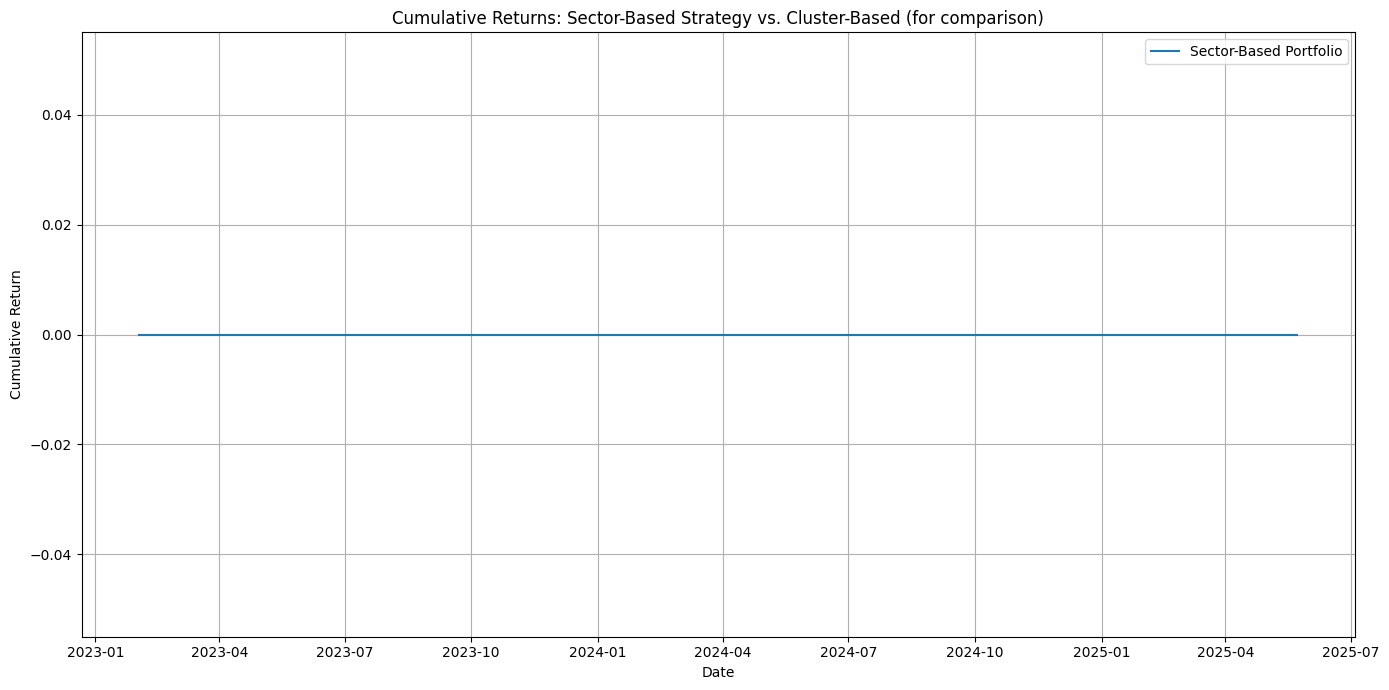


--- Comparison of Annualized Returns ---
Sector-Based Annualized Return:  0.0000


In [40]:
# Define sector-specific parameters
my_num_top_sectors = 2    # Number of top sectors to long
my_num_bottom_sectors = 1 # Number of bottom sectors to short

# Call the sector-based simulation function
cumulative_returns_sector, performance_metrics_sector = simulate_sector_based_portfolio(
    residuals=residuals,
    stock_returns=stock_returns,
    stock_sectors_df=sector_stocks_cleaned, # Pass your sector data here

    lookback_window_days=my_lookback_window_days,
    rebalance_frequency_days=my_rebalance_frequency_days,
    num_top_sectors=my_num_top_sectors,
    num_bottom_sectors=my_num_bottom_sectors,
    proportion_to_invest=my_proportion_to_invest,
    initial_capital=my_initial_capital,

    verbose=True
)

# --- Now you can compare the results ---
# Call your cluster-based simulation function as well for comparison
# cumulative_returns_cluster, performance_metrics_cluster = simulate_rebalancing_portfolio(...)

# Plotting both for comparison
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns_sector.index, cumulative_returns_sector.values, label='Sector-Based Portfolio')
# plt.plot(cumulative_returns_cluster.index, cumulative_returns_cluster.values, label='Cluster-Based Portfolio') # Uncomment to plot both
plt.title('Cumulative Returns: Sector-Based Strategy vs. Cluster-Based (for comparison)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Comparison of Annualized Returns ---")
# print(f"Cluster-Based Annualized Return: {performance_metrics_cluster['annualized_return']:.4f}")
print(f"Sector-Based Annualized Return:  {performance_metrics_sector['annualized_return']:.4f}")

In [41]:
performance_metrics_sector['portfolio_value_history'][performance_metrics_sector['portfolio_value_history'].index == '2024-12-27']

Date
2024-12-27    100000.0
dtype: float64

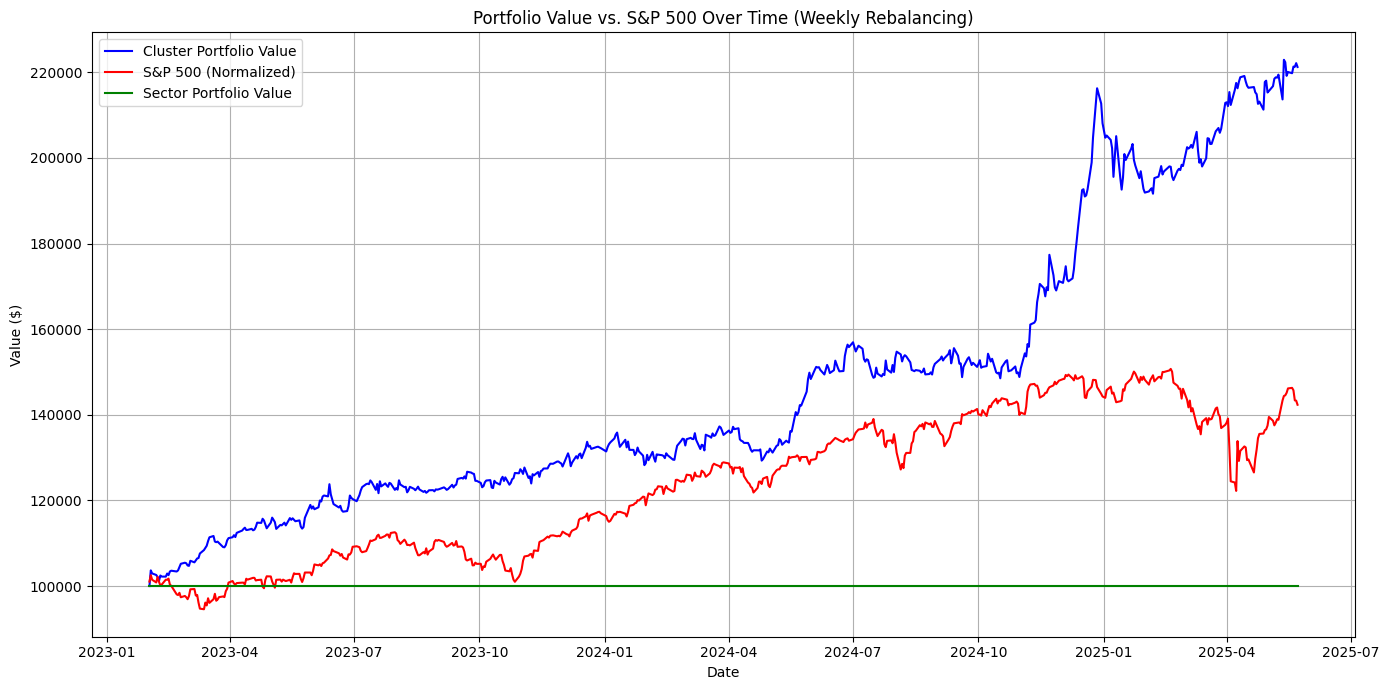

In [42]:
plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.plot(portfolio_value_aligned.index, portfolio_value_aligned.values, label='Cluster Portfolio Value', color='blue')

# Overlay S&P 500 Return
plt.plot(sp500_normalized_value_aligned.index, sp500_normalized_value_aligned.values, label='S&P 500 (Normalized)', color='red')

plt.plot(performance_metrics_sector['portfolio_value_history'].index, performance_metrics_sector['portfolio_value_history'].values, label='Sector Portfolio Value', color='green')

plt.title('Portfolio Value vs. S&P 500 Over Time (Weekly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
